In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [3]:
from constants import *

In [4]:
import matplotlib.pyplot as plt

### Old way of pulling out corpus

In [5]:
with open(f'{CONCAT_DIR}/concat_corpus.utf') as f:
    train_contents = f.read()

In [6]:
train_contents[0:10]

'їPÿ\x07{\x919\x05)\x1c'

In [7]:
import h5py    
import numpy as np    
import json
concat_h5 = h5py.File(f'{CONCAT_DIR}/concat_corpus.h5','r+') 

with open(f'{CONCAT_DIR}/concat_corpus.json', 'rb') as f:
    concat_json = json.load(f)

/home/paperspace/anaconda3/envs/music/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
t = concat_h5['train']

In [9]:
t[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

### One hot encoding

In [10]:
def one_hot(a,c): 
    return np.eye(c)[a]

In [11]:
class MusicDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, h5_file, set_type, json_file, timesteps, root_dir):
        self.concat_h5 = h5py.File(f'{root_dir}/{h5_file}','r+')
        self.dataset = self.concat_h5[set_type]
        with open(f'{root_dir}/{json_file}', 'rb') as f:
            self.concat_json = json.load(f)
        self.vocab_size = len(self.concat_json['idx_to_token'])+1
        self.data_length = self.dataset.shape[0]
        self.timesteps = timesteps

    def __len__(self):
        return (self.data_length // self.timesteps)

    def __getitem__(self, idx):
        start = idx*self.timesteps
        x = self.dataset[start:start+self.timesteps]
        y = self.dataset[start+1:start+self.timesteps+1]
        return x, y


In [12]:
batch_size = 64
timesteps = 64
md = MusicDataset(h5_file='concat_corpus.h5', set_type='train', json_file='concat_corpus.json', timesteps=timesteps, root_dir=CONCAT_DIR)

In [13]:
train_loader = torch.utils.data.DataLoader(md,
    batch_size=batch_size)

### Dataset sanity test

In [14]:
train_iter = enumerate(train_loader)

In [15]:
i, (x, y) = next(train_iter)
i2, (x2, y2) = next(train_iter)

In [16]:
md.dataset[:100]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  6,  6,  6, 11,  3, 12, 13,
        6, 14,  8, 15, 16,  6, 14,  8,  4, 16,  6, 14,  8,  9, 16,  6,  2,
       17, 18, 19,  6,  7, 20, 21, 22,  6, 23, 20, 21, 22,  6, 24, 20, 21,
       22,  6, 25,  3, 26, 27,  6, 28,  8, 29, 30,  6, 23,  8, 29, 30,  6,
       24,  8, 29, 30,  6,  2, 17, 18, 31,  6,  7, 20, 21, 32,  6,  7, 20,
        4,  5,  6,  7, 20,  9, 10,  6, 23, 26, 12, 18,  6, 24, 29],
      dtype=uint8)

### Model

In [17]:
cuda_enabled = torch.cuda.is_available()

In [18]:
def repackage_var(h):
    """Wraps h in new Variables, to detach them from their history."""
    if type(h) == torch.autograd.Variable:
        v = torch.autograd.Variable(h.data)
        return v.cuda() if cuda_enabled else v
    else:
        return tuple(repackage_var(v) for v in h)

In [19]:
class StatefulLSTM(torch.nn.Module):
    def __init__(self, scale_size, n_hidden, n_factors, bs, nl):
        super().__init__()
        self.scale_size = scale_size
        self.nl = nl
        self.embedding = torch.nn.Embedding(scale_size, n_factors)
        
        self.rnn1 = torch.nn.LSTM(n_factors, n_hidden, nl, dropout=0.5, batch_first=True)
        self.rnn2 = torch.nn.LSTM(n_hidden, n_hidden, nl, dropout=0.5, batch_first=True)
        self.rnn3 = torch.nn.LSTM(n_hidden, n_hidden, nl, dropout=0.5, batch_first=True)
        
        if cuda_enabled:
            self.rnn1 = self.rnn1.cuda()
            self.rnn2 = self.rnn2.cuda()
            self.rnn3 = self.rnn3.cuda()
        
        self.bn1 = nn.utils.weight_norm(self.rnn1, 'weight_hh_l0')
        self.bn1 = nn.utils.weight_norm(self.bn1, 'weight_ih_l0')
        self.bn2 = nn.utils.weight_norm(self.rnn2, 'weight_hh_l0')
        self.bn2 = nn.utils.weight_norm(self.bn2, 'weight_ih_l0')
        self.bn3 = nn.utils.weight_norm(self.rnn3, 'weight_hh_l0')
        self.bn3 = nn.utils.weight_norm(self.bn3, 'weight_ih_l0')
        
        # pytorch rnn does not currently work with batchnorm
        self.l_out = torch.nn.Linear(n_hidden, scale_size)
        self.n_hidden = n_hidden
        self.reset_all_hidden(bs)
        self.bs = bs
        
    def forward(self, notes):
        bs = notes.shape[0]
        if self.h1[0].size(1) != bs: 
            self.reset_all_hidden(bs)
        emb = self.embedding(notes)
#         outp1,h1 = self.rnn1(emb, self.h1)
        outp1,h1 = self.bn1(emb, self.h1)
        outp2,h2 = self.bn2(outp1, self.h2)
        outp3,h3 = self.bn3(outp2, self.h3)
        self.h1 = repackage_var(h1)
        self.h2 = repackage_var(h2)
        self.h3 = repackage_var(h3)
        return torch.nn.functional.log_softmax(self.l_out(outp3), dim=-1).view(-1, self.scale_size)
#         return torch.nn.functional.log_softmax(self.l_out(outp[:, -1, :]), dim=-1)
#         return torch.nn.functional.softmax(self.l_out(outp[:, -1, :]), dim=-1)
    
    def reset_all_hidden(self, bs):
        self.h1 = self.init_hidden(bs)
        self.h2 = self.init_hidden(bs)
        self.h3 = self.init_hidden(bs)
        
    def init_hidden(self, bs):
        h1 = torch.autograd.Variable(torch.zeros(self.nl, bs, self.n_hidden))
        h2 = torch.autograd.Variable(torch.zeros(self.nl, bs, self.n_hidden))
        if cuda_enabled:
            return (h1.cuda(), h2.cuda())
        return h1, h2

### Training

In [20]:
m = StatefulLSTM(md.vocab_size, n_hidden=256, n_factors=10, bs=batch_size, nl=2)
if cuda_enabled:
    m = m.cuda()

In [21]:
train_op = torch.optim.Adam(m.parameters(), lr=1e-3)

In [22]:
loss_fn = torch.nn.NLLLoss()

In [26]:
display_step = 100
training_steps = 20
for step in range(training_steps):
# for step in tqdm(range(training_steps)):
    for i, (data,target) in enumerate(train_loader):
        data, target = torch.autograd.Variable(data.long()), torch.autograd.Variable(target.long())
        if cuda_enabled:
            data, target = data.cuda(), target.cuda()
        m.zero_grad()
        forward = m(data)
        loss = loss_fn(forward, target.view(-1))
        loss.backward()
        train_op.step()
        if ((i+1) % display_step == 0):
            print(f'Iteration: {i+1} Loss: {loss.data[0]}')
    print(f'Step: {step} Loss: {loss.data[0]}')

Step: 0 Loss: 0.8837975859642029
Step: 1 Loss: 0.8262671828269958
Step: 2 Loss: 0.8231990933418274
Step: 3 Loss: 0.7826149463653564
Step: 4 Loss: 0.7490541338920593
Step: 5 Loss: 0.7290158271789551
Step: 6 Loss: 0.7456340193748474
Step: 7 Loss: 0.7154475450515747
Step: 8 Loss: 0.7040112018585205
Step: 9 Loss: 0.6871640682220459
Step: 10 Loss: 0.6744714975357056
Step: 11 Loss: 0.6658293008804321
Step: 12 Loss: 0.6595748066902161
Step: 13 Loss: 0.659454345703125
Step: 14 Loss: 0.6373581290245056
Step: 15 Loss: 0.6342001557350159
Step: 16 Loss: 0.6275112628936768
Step: 17 Loss: 0.6268845200538635
Step: 18 Loss: 0.6096925139427185
Step: 19 Loss: 0.6116015911102295


### Saving model

In [27]:
model_path = f'{OUT_DIR}/../models/bachbot_stackedlstm_rnn_t64.h5'

In [28]:
torch.save(m.state_dict(), model_path)

In [24]:
if cuda_enabled:
    m.load_state_dict(torch.load(model_path))
else:
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))

### Generate music

Need to have unknown state 0?

In [29]:
timesteps = md.timesteps

In [31]:
def generate_sequence(song, seq_length):
    full_song = song.tolist()
    # generate music!
    m.reset_all_hidden(batch_size)
    for i in range(seq_length):
        seed = np.array([full_song[-timesteps:]])
        # Use our RNN for prediction using our seed! 
        seed_v = torch.autograd.Variable(torch.from_numpy(seed).long())
        if cuda_enabled:
            seed_v = seed_v.cuda()
        predict_probs = m(seed_v)

#         percentage_prob = torch.exp(predict_probs)
        # Define output vector for our generated song by sampling from our predicted probability distribution
        
    #     sampled_note = np.random.choice(range(md.vocab_size), p=percentage_prob[0]) # TODO
#         sampled_note = np.argmax(percentage_prob)
    #     print('Sampled_note:', sampled_note)
        
        # With multi output model, use only the last prediction. As it is predicting to n timesteps
        v, idx = torch.max(torch.exp(predict_probs[-1]), 0)
        full_song.append(idx.data[0])
    return full_song
    


In [34]:
def get_x_input(partial):
    _, _, _, seq = partial
    input = seq[-timesteps:]
    input_var = torch.autograd.Variable(torch.LongTensor([input]))
    if cuda_enabled:
        input_var = input_var.cuda()
    return input_var

# song = string
# seq_length = generated song length
# beam_size = what to choose from
def beam_search(song, seq_length, beam_size):    
    full_song = song.tolist()
    m.reset_all_hidden(batch_size)
    partial_sequences = [(0, 0, [], full_song)]
    m.eval()

    for i in range(seq_length):
        partial_sequences = find_partials(partial_sequences, beam_size)
        
    final_sequence = partial_sequences[0][3]
    return final_sequence
    
def find_partials(partial_sequences, beam_size):
    partial_next = []
    for partial in partial_sequences:
        it, tot_p, p_list, seq = partial
        x_input = get_x_input(partial)

        predict_probs = m(x_input)
        # last_it_probs = torch.exp(predict_probs[-(it+1):]) # this is to predict the last few iterations
        last_it_probs = torch.exp(predict_probs[-1:])
        top, idxs = torch.topk(last_it_probs, beam_size, 1)

        for i in range(beam_size):
            prob = top.data[0][i]
            idx = idxs.data[0][i]
            new_p_list = p_list+[prob]
            partial_next.append((it+1, np.mean(new_p_list), new_p_list, seq+[idx]))

    partial_sequences = sorted(partial_next, key=lambda x: x[1], reverse=True)[:3]
    return partial_sequences

In [ ]:
def random_choice(top, idxs):
    return np.random.choice(
      idxs.data.numpy().reshape(-1), 
      1,
      p=(top/top.sum()).data.numpy().reshape(-1)
    )

### Beam search end - Decoding time

In [38]:
import decode

In [39]:
def decode_output(output_idx):
    idx2token = md.concat_json['idx_to_token']
    token_list = list(map(lambda x: idx2token.get(str(x), ''), output_idx))
    return decode_token(token_list)

def decode_token(token_list):
    if (token_list[0] != START_DELIM):
        token_list.insert(0, START_DELIM)
    token_str = ''.join(token_list)
    with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
        utf_to_txt = json.load(f)
    score, stream = decode.decode_string(utf_to_txt, token_str)
    return token_str, score, stream

# test = [idx2token[f'{x}'] for x in seq_arr]; test

In [40]:
song_seed = md.dataset[:md.timesteps]
# generated_idxs = generate_sequence(song_seed, 500)

In [41]:
bs_gen_idxs = beam_search(song_seed, 500, 3)

In [42]:
gen_idxs = generate_sequence(song_seed, 500)

In [54]:
bs_gen_idxs[-10:]

[32, 6, 25, 33, 4, 5, 6, 28, 34, 9]

In [55]:
gen_idxs[-10:]

[6, 35, 6, 35, 6, 35, 6, 35, 6, 35]

In [56]:
bs_token_str, bs_score, bs_stream = decode_output(bs_gen_idxs)

In [57]:
token_str, score, stream = decode_output(gen_idxs)

In [58]:
bs_token_str

'їPÿ\x07{\x919\x05)\x1c\x91\x91\x91Ûÿ+è\x91¤\x05ÐÈ\x91¤\x05\x07È\x91¤\x05)È\x91P,t~\x919àæB\x91ÅàæB\x91FàæB\x91þÿîµ\x91ç\x05Õh\x91Å\x05Õh\x91F\x05Õh\x91Pÿ\x9eí\x919\x05ï\x9a\x919\x05ïè\x919\x05ïÈ\x91á,\x9e~\x91\x17àïB\x91\x17à+B\x91\x17àÐB\x91\x84ÿ\x9e\x07Ù\x91\x84\x05ï)%\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84ћїÿ\x9e\x07{\x91\x05ï)\x1c\x91\x91\x91ÿî\x07µ\x91\x05Õ)h\x91\x91\x91á\x9etH\x91\x17ïæã\x91\x91\x91þ\x9e{\x91çï\x1c\x91çï\x1cH\x91çï\x1cã\x91Åî{µ\x91FÕ\x1ch\x91FÕtH\x91FÕæã\x91þ\x9e\x07{\x91çï)\x1c\x91çïtH\x91çïæã\x91Åî{µ\x91FÕ\x1ch\x91FÕtH\x91FÕæã\x91þ\x9e\x07{\x91çï)\x1c\x91çïtH\x91çïæã\x91Åî{µ\x91FÕ\x1ch\x91FÕtH\x91FÕæã\x91þ\x9e\x07{\x91çï)\x1c\x91çïtH\x91çïæã\x91Åî{µ\x91FÕ\x1ch\x91FÕtH\x91FÕæã\x91þ\x9e\x07{\x91çï)\x1c\x91çïtH\x91çïæã\x91Åî{µ\x91FÕ\x1ch\x91FÕtH\x91FÕæã\x91þ\x9e\x07{\x91çï)\x1c\x91çïtH\x91çïæã\x91Åî{µ\x91FÕ\x1ch\x91FÕtH\x91FÕæã\x91þ\x9e\x07{\x91çï)\x1c\x91çïtH

In [59]:
token_str

'їPÿ\x07{\x919\x05)\x1c\x91\x91\x91Ûÿ+è\x91¤\x05ÐÈ\x91¤\x05\x07È\x91¤\x05)È\x91P,t~\x919àæB\x91ÅàæB\x91FàæB\x91þÿîµ\x91ç\x05Õh\x91Å\x05Õh\x91F\x05Õh\x91Pá\x9eH\x919\x17ïã\x919\x17ïã\x919\x17ïã\x91Åþ\x9e{\x91sçï\x1c\x91\x91\x91<á\x9eH\x91<\x17ïã\x91\x91\x91þÿ\x9e{\x91ç\x05ï\x1c\x91ç\x05ïH\x91ç\x05ïã\x91Åÿîµ\x91F\x05Õh\x91\x91\x91Pá\x9eH\x919\x17ïã\x91\x91\x91þÿ\x9e{\x91ç\x05ï\x1c\x91\x91\x91áÿîè\x91\x17\x05ÕÈ\x91\x91\x91\x17,\x9e~\x91\x17àïB\x91\x91\x91\x84þÿ\x9eÙ\x91\x84ç\x05ï%\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91þÿ\x9e{\x91ç\x05ï\x1c\x91\x91\x91áÿ\x9e~\x91\x17\x05ïB\x91\x91\x91\x17,ïB\x91\x17àïB\x91\x91\x91\x84þÿ\x9eÙ\x91\x84ç\x05ï%\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91þÿ\x9e{\x91ç\x05ï\x1c\x91\x91\x91áÿ\x9e~\x91\x17\x05ïB\x91\x91\x91\x17,ïB\x91\x17àïB\x91\x91\x91\x84þÿ\x9eÙ\x91\x84ç\x05ï%\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91\x84\x91þÿ\x9e{\x91ç\x05ï\x1c\

In [ ]:
score

### For testing stuff

In [45]:
with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
    utf_to_txt = json.load(f)

In [65]:
test_str = train_contents[:500]

In [ ]:
with open(f'{SCRATCH_DIR}/BWV-400-nomask-fermatas.utf', 'r') as f:
    test_str = f.read()[:500]

In [66]:
orig_token_str, orig_score, orig_stream = decode_token(test_str)

In [67]:
orig_stream.elements[:10]

(<music21.chord.Chord G5 C5 E4 C4>,
 <music21.chord.Chord G5 C5 E4 C4>,
 <music21.note.Rest rest>,
 <music21.note.Rest rest>,
 <music21.chord.Chord A5 C5 F4 F3>,
 <music21.chord.Chord A5 C5 F4 F3>,
 <music21.chord.Chord A5 C5 E4 F3>,
 <music21.chord.Chord A5 C5 E4 F3>,
 <music21.chord.Chord G5 B4 D4 G3>,
 <music21.chord.Chord G5 B4 D4 G3>)

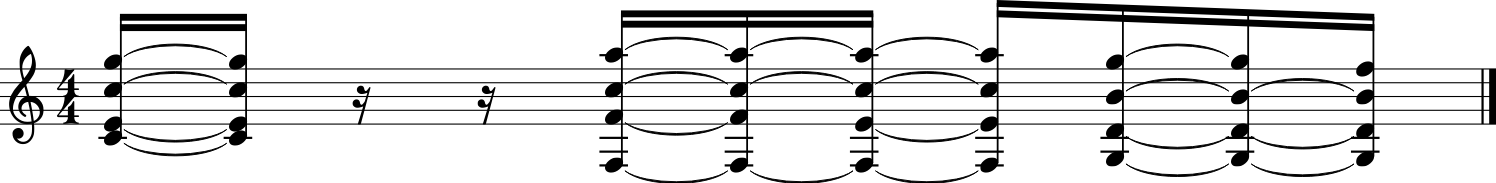

In [68]:
orig_stream.show()

### Evaluate stream

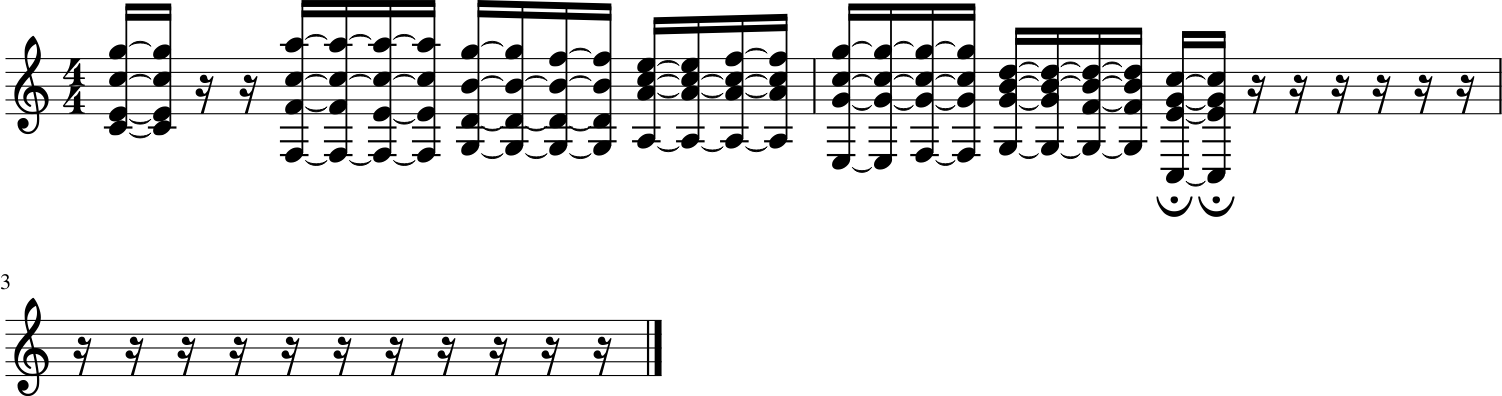

In [60]:
bs_stream.show()

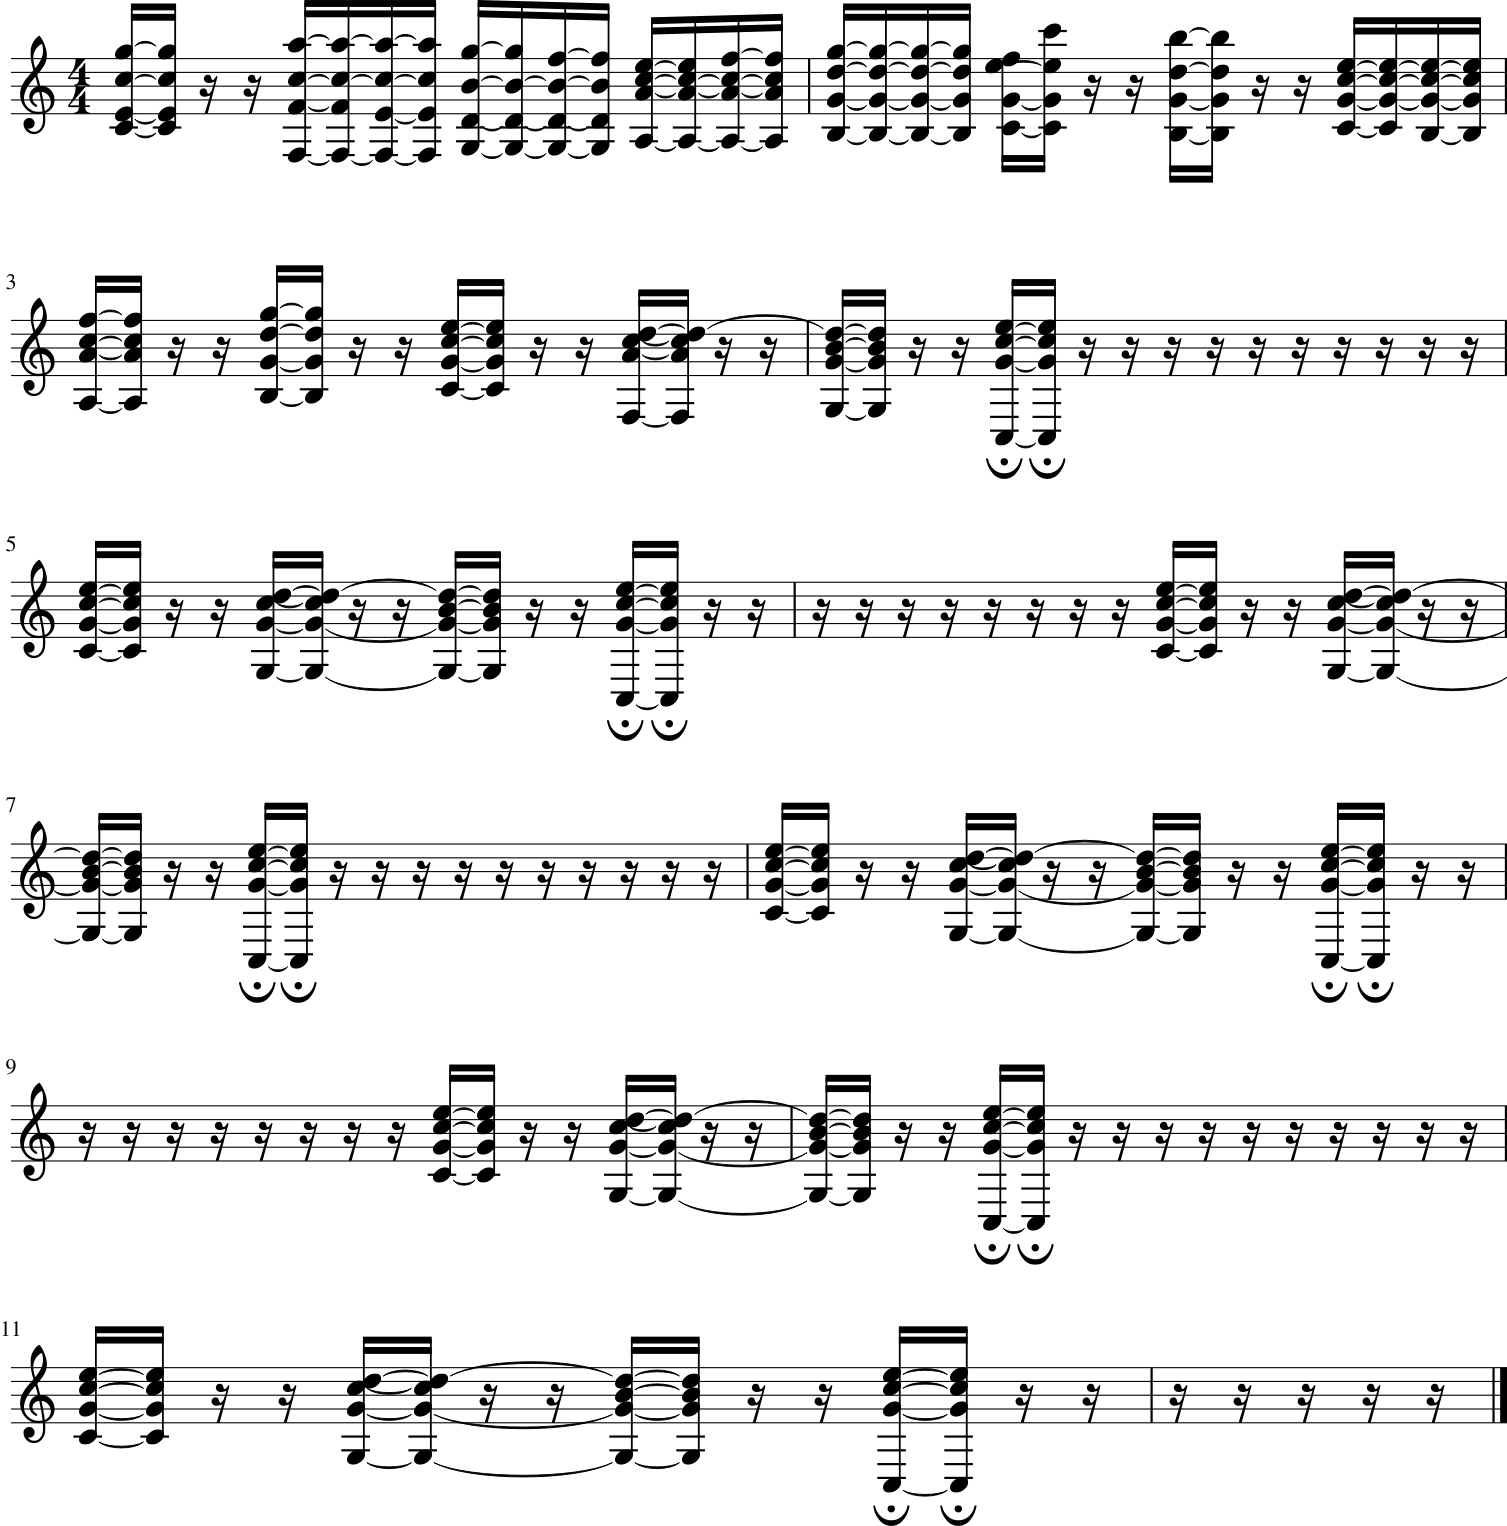

In [61]:
stream.show()

In [ ]:
fp = stream.write('midi', fp=f'{OUT_DIR}/testout.midi')

In [74]:
fp = stream.write('xml', fp=f'{OUT_DIR}/testout8.xml')

In [73]:
from IPython.lib.display import FileLink
FileLink('../data/bachbot/out/testout8.xml')

/home/paperspace/music_rnn/data/bachbot/out/testout9.xml

In [ ]:
music21.environment.get('musicxmlPath')

In [ ]:
music21.environment.set('music')